# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on April 12, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 1. The logistic model was applied to 85 countries
### 2. Mean turning point for these countries is on 2020-03-29 (This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-04-29
### 4. The numbers of confirmed cases in  US, France, United Kingdom may exceed those in China by May, 2020
### 5. Comparing to last week, more countries can be modeled by logistic model, indicating that an increase in number of confirmed cases globally 
### 6. Looking at top 5 countries, model predicts a decrease in last week but the number increased in reality. It could be due to increased number of tests done but it also proves that the model tend to underestimate the situation.
### 7. The earliset time for situation in most countries to be stablized is in the begining of May 
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,273,281,299,349,367,423,444,484,521,555
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,277,304,333,361,377,383,400,409,416,433
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,986,1171,1251,1320,1423,1468,1572,1666,1761,1825
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,428,439,466,501,525,545,564,583,601,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,10,14,16,17,19,19,19,19


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,582,584,585,586,587,587,588,588,588,589
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,345,349,350,350,350,351,351,351,351,351
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,138,138,138,138,139,139,139,139,139,139


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

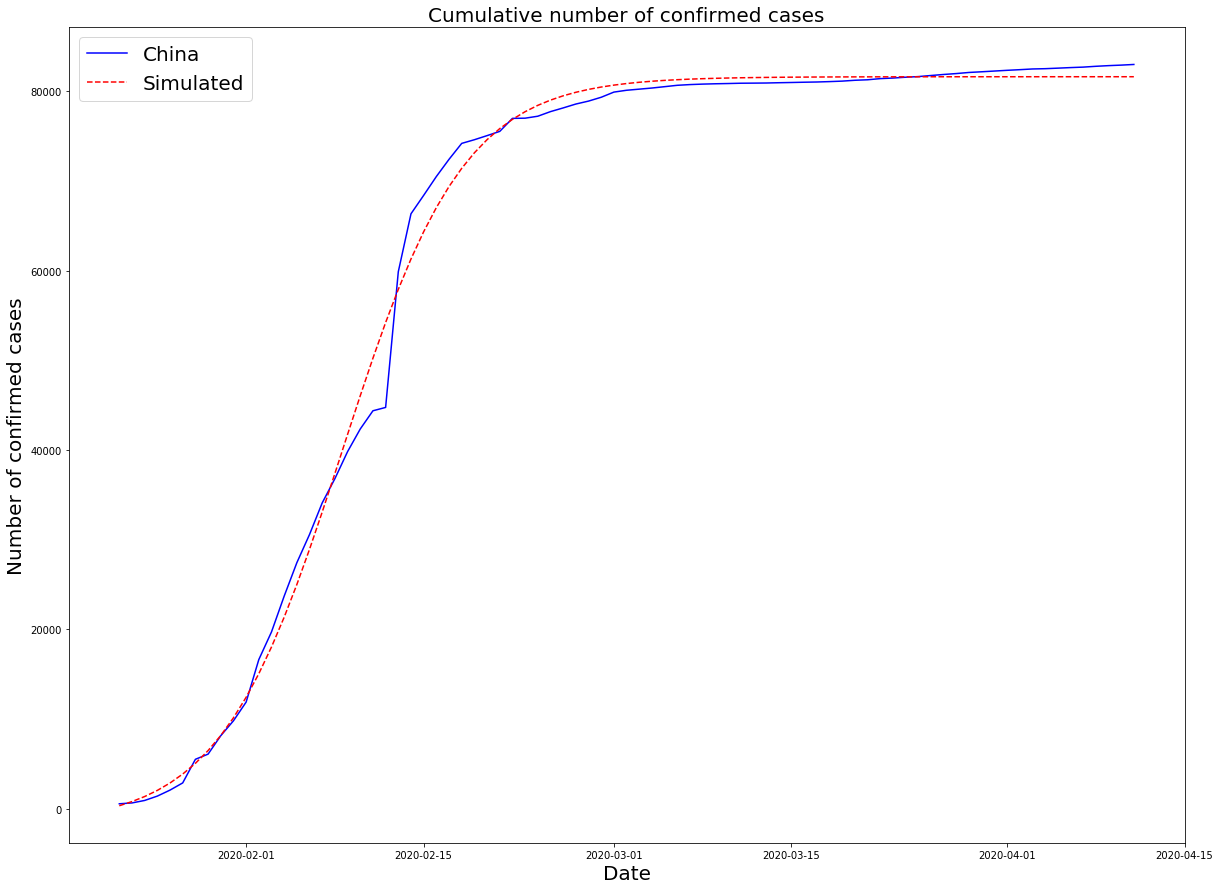

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9958381268635693


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 18:54:12.165292800


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-12 16:59:36.938601600
The total number of confirmed cases is  81646.29673109476


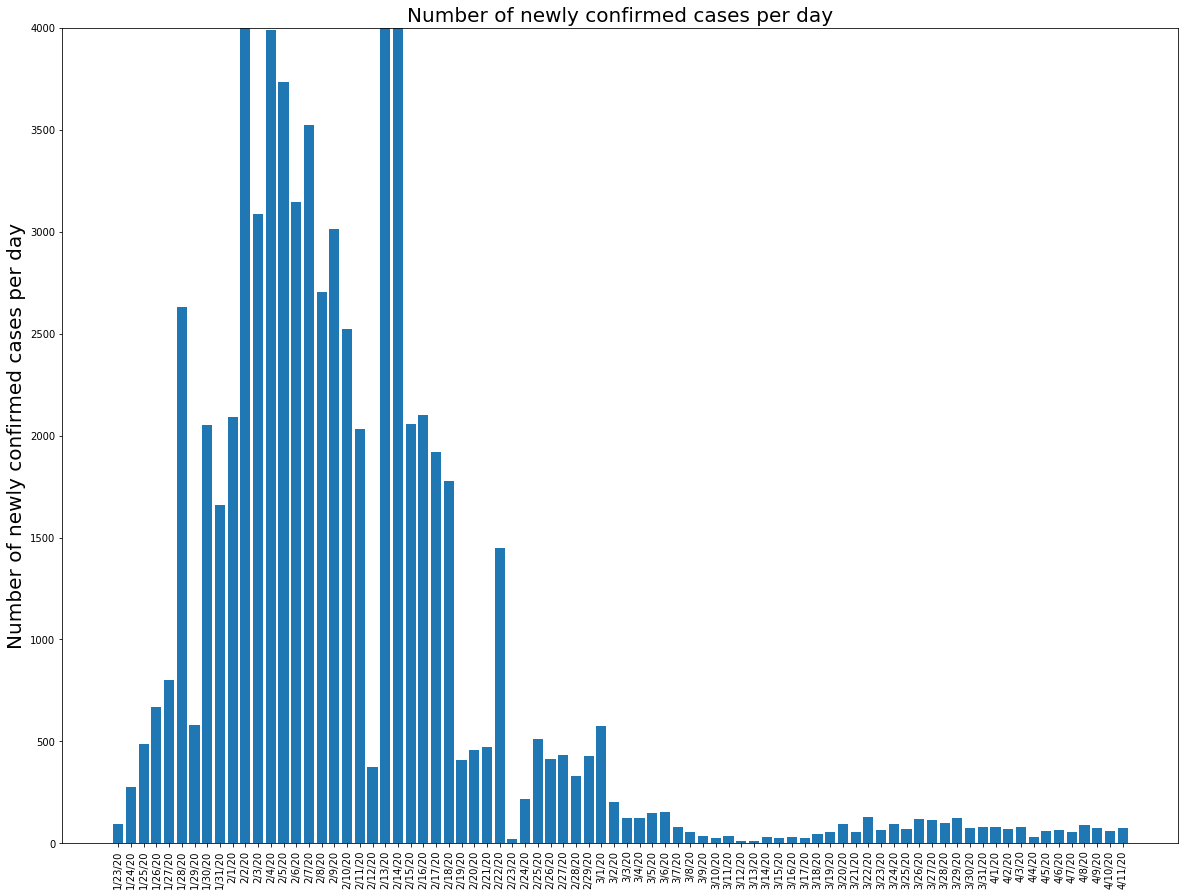

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]]);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy());
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Afghanistan
R^2 =  0.9977844918988544
The day reaches the turning point is on:  2020-04-06 01:13:38.627932800
The day reaches the top of the curve is on:  2020-05-13 07:41:27.356928
The total number of confirmed cases is  767.9846325013975
Albania
R^2 =  0.998011143872746
The day reaches the turning point is on:  2020-02-19 14:39:29.116569600
The day reaches the top of the curve is on:  2020-01-10 23:54:10.235433600
The total number of confirmed cases is  -1.7533073596964641
Algeria
R^2 =  0.9984703566760558
The day reaches the turning point is on:  2020-04-02 20:19:39.851414400
The day reaches the top of the curve is on:  2020-05-05 09:30:07.330579200
The total number of confirmed cases is  2136.6788821154946
Andorra
R^2 =  0.9970050923746876
The day reaches the turning point is on:  2020-03-28 20:38:20.680598400
The day reaches the top of the curve is on:  2020-04-29 08:51:38.244268800
The total number of confirmed cases is  620.0566225826046
Argentina
R^2 =  0.9980125609341862
The d

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Belarus
R^2 =  0.9948280853093956
The day reaches the turning point is on:  2020-04-19 21:06:34.925500800
The day reaches the top of the curve is on:  2020-05-17 10:13:03.980064
The total number of confirmed cases is  23574.623828535936
Belgium
R^2 =  0.9988001370262327
The day reaches the turning point is on:  2020-04-02 18:21:17.081164800
The day reaches the top of the curve is on:  2020-05-10 09:48:22.576464
The total number of confirmed cases is  33175.9801542148
Bosnia and Herzegovina
R^2 =  0.9987608849425365
The day reaches the turning point is on:  2020-04-03 06:27:48.288614400
The day reaches the top of the curve is on:  2020-05-10 22:40:26.733590400
The total number of confirmed cases is  1154.3386881344836
Brazil
R^2 =  0.9986098758492425
The day reaches the turning point is on:  2020-04-10 12:07:47.952422400
The day reaches the top of the curve is on:  2020-05-21 09:42:24.740582400
The total number of confirmed cases is  40393.441151682
Bulgaria
R^2 =  0.9976685277948945
Th

C:\Users\erwin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Kazakhstan
R^2 =  0.9979165563363473
The day reaches the turning point is on:  2020-04-03 05:46:05.010614400
The day reaches the top of the curve is on:  2020-05-04 12:59:49.236316799
The total number of confirmed cases is  1000.4691869088361
Korea, South
R^2 =  0.9902173521338451
The day reaches the turning point is on:  2020-03-03 14:47:36.000528
The day reaches the top of the curve is on:  2020-04-05 09:27:55.185494400
The total number of confirmed cases is  9635.82435912403
Latvia
R^2 =  0.9990828358675155
The day reaches the turning point is on:  2020-03-28 10:36:47.832105600
The day reaches the top of the curve is on:  2020-05-01 23:04:25.380854400
The total number of confirmed cases is  650.3791753892331
Lebanon
R^2 =  0.9979021042267799
The day reaches the turning point is on:  2020-02-11 17:45:50.486774400
The day reaches the top of the curve is on:  2020-01-07 23:15:27.948153600
The total number of confirmed cases is  -0.7114292313574424
Lithuania
R^2 =  0.997782659914724
The

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  85


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
83,US,0.999313,2020-04-04 17:37:12.500889600,2020-05-09 00:21:38.722118400,661979
33,France,0.996757,2020-04-05 15:15:43.600752,2020-05-17 19:24:11.511993600,189060
81,United Kingdom,0.999124,2020-04-07 07:28:18.605798399,2020-05-16 09:49:45.651014400,118783
19,China,0.995838,2020-02-08 18:54:12.165984,2020-03-12 16:59:36.921235200,81646.3
78,Turkey,0.998148,2020-04-07 18:01:34.773542399,2020-05-10 07:17:35.618035200,76156.5
67,Russia,0.999492,2020-04-15 08:44:10.053427200,2020-05-21 19:21:33.391094400,44483.7
13,Brazil,0.99861,2020-04-10 12:07:47.952422400,2020-05-21 09:42:24.740582400,40393.4
11,Belgium,0.9988,2020-04-02 18:21:17.081164800,2020-05-10 09:48:22.576464,33176
17,Canada,0.999205,2020-04-04 17:18:58.577097600,2020-05-09 19:19:07.475145600,29674.9
55,Netherlands,0.998694,2020-04-01 07:53:13.899667200,2020-05-12 19:24:06.718521600,28193.5


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-03-29 11:06:56.799755520
Mean CurveTop for these countries is  2020-04-29 19:12:42.501359616


## Examples

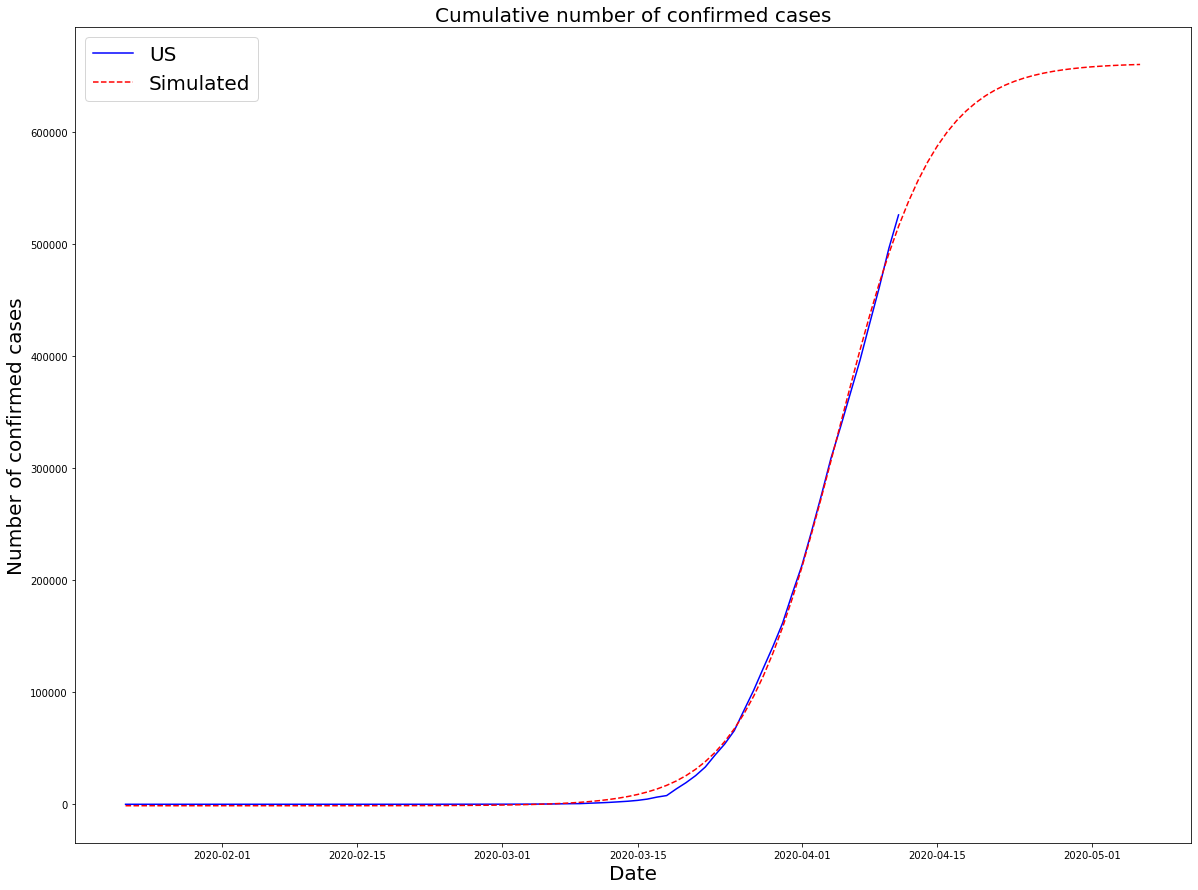

In [17]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

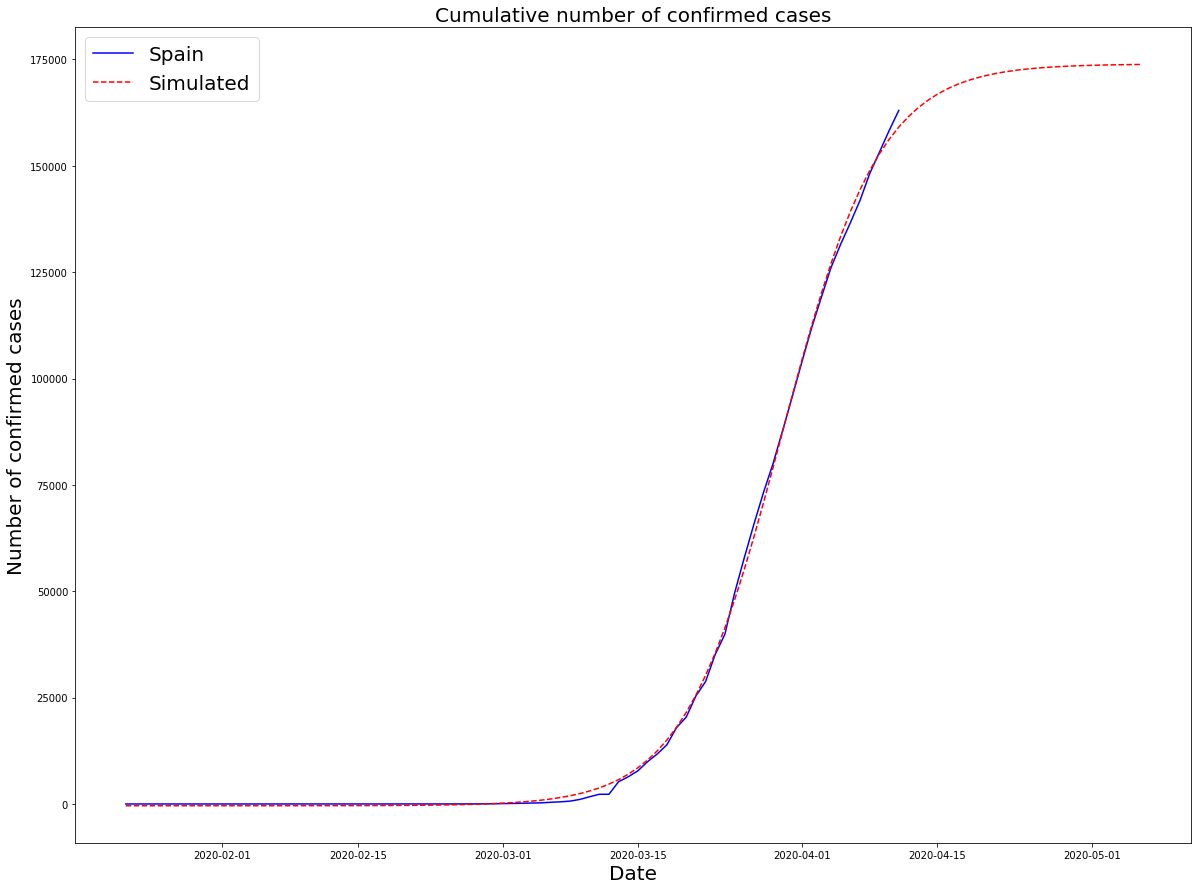

In [18]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

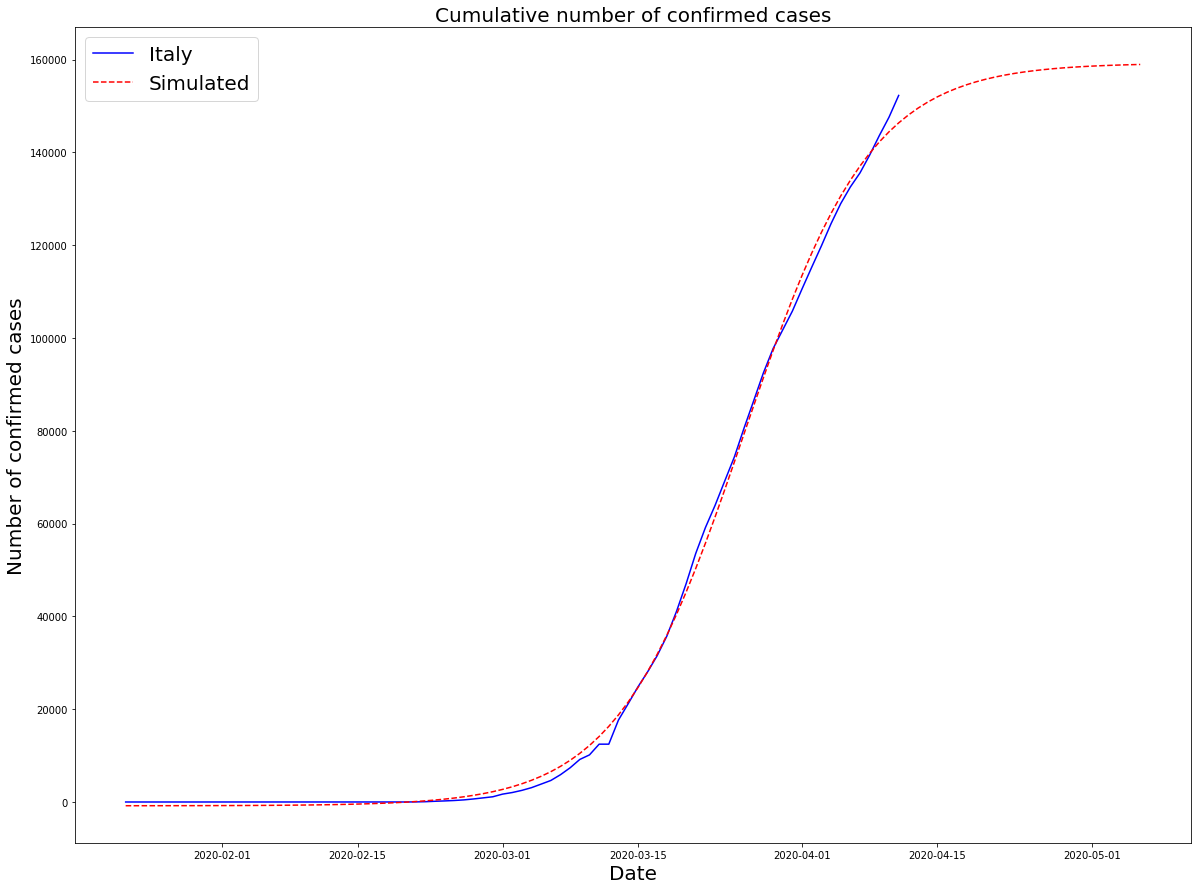

In [19]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

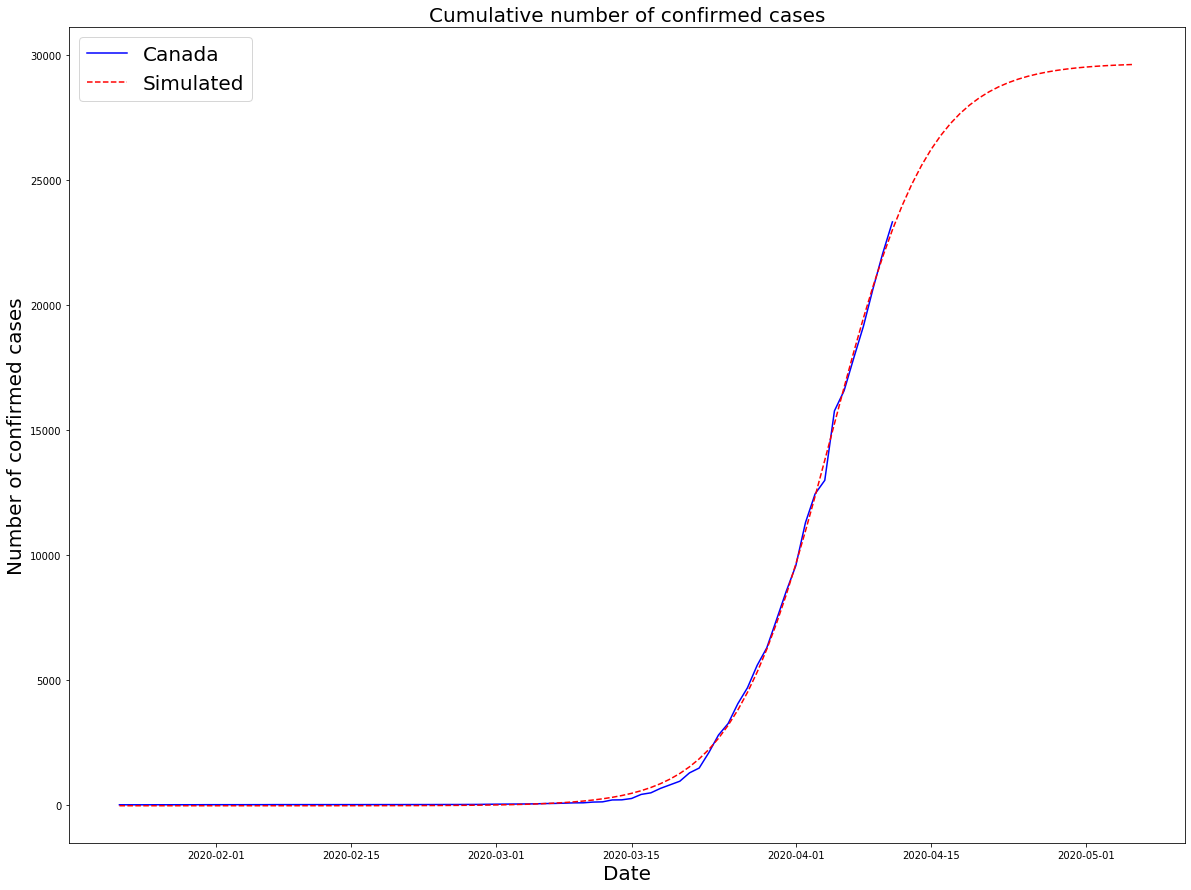

In [20]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);